In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# CNN - Transfer learning model -> Dense Network

### Import Tools and librarries

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf # since we are using keras library we need deep learning model, tensorflow
from tqdm import tqdm # it is used to show progess bar

## NLP imports
from tensorflow.keras.preprocessing.text import Tokenizer # this is used to convert text into sequesnce of numbers
from tensorflow.keras.preprocessing.sequence import pad_sequences  # padding to sequence the data
from tensorflow.keras.utils import to_categorical ## For OHE
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Embedding, LSTM, Concatenate, Reshape, Bidirectional, add ## For createing LSTM RNN

## Model creation imports
from tensorflow.keras.models import Sequential, Model ## Sequence for sequence

## Computer vision imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from tensorflow.keras.applications import DenseNet201 ## CNN

# Model learning and Losses imports
from tensorflow.keras.optimizers import Adam # updating weights ke liye konsa learning rate better ha
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau 
## ModelCheckpoint for dynamic saving the model with better value in a particular epocs
## EarlyStopping for stopping overfitting dynamically
## ReduceLearningRateOnPlateau gives us a hold to choose the best learning rate

# Warning & Visualization Imports 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')


2025-09-01 05:44:11.637875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756705451.858356      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756705451.921608      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Dataset

In [4]:
image_path = "/kaggle/input/flickr8k/Images"
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
data.head

<bound method NDFrame.head of                            image  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                 caption  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452 

### Visualization

* images and their corresponding captions

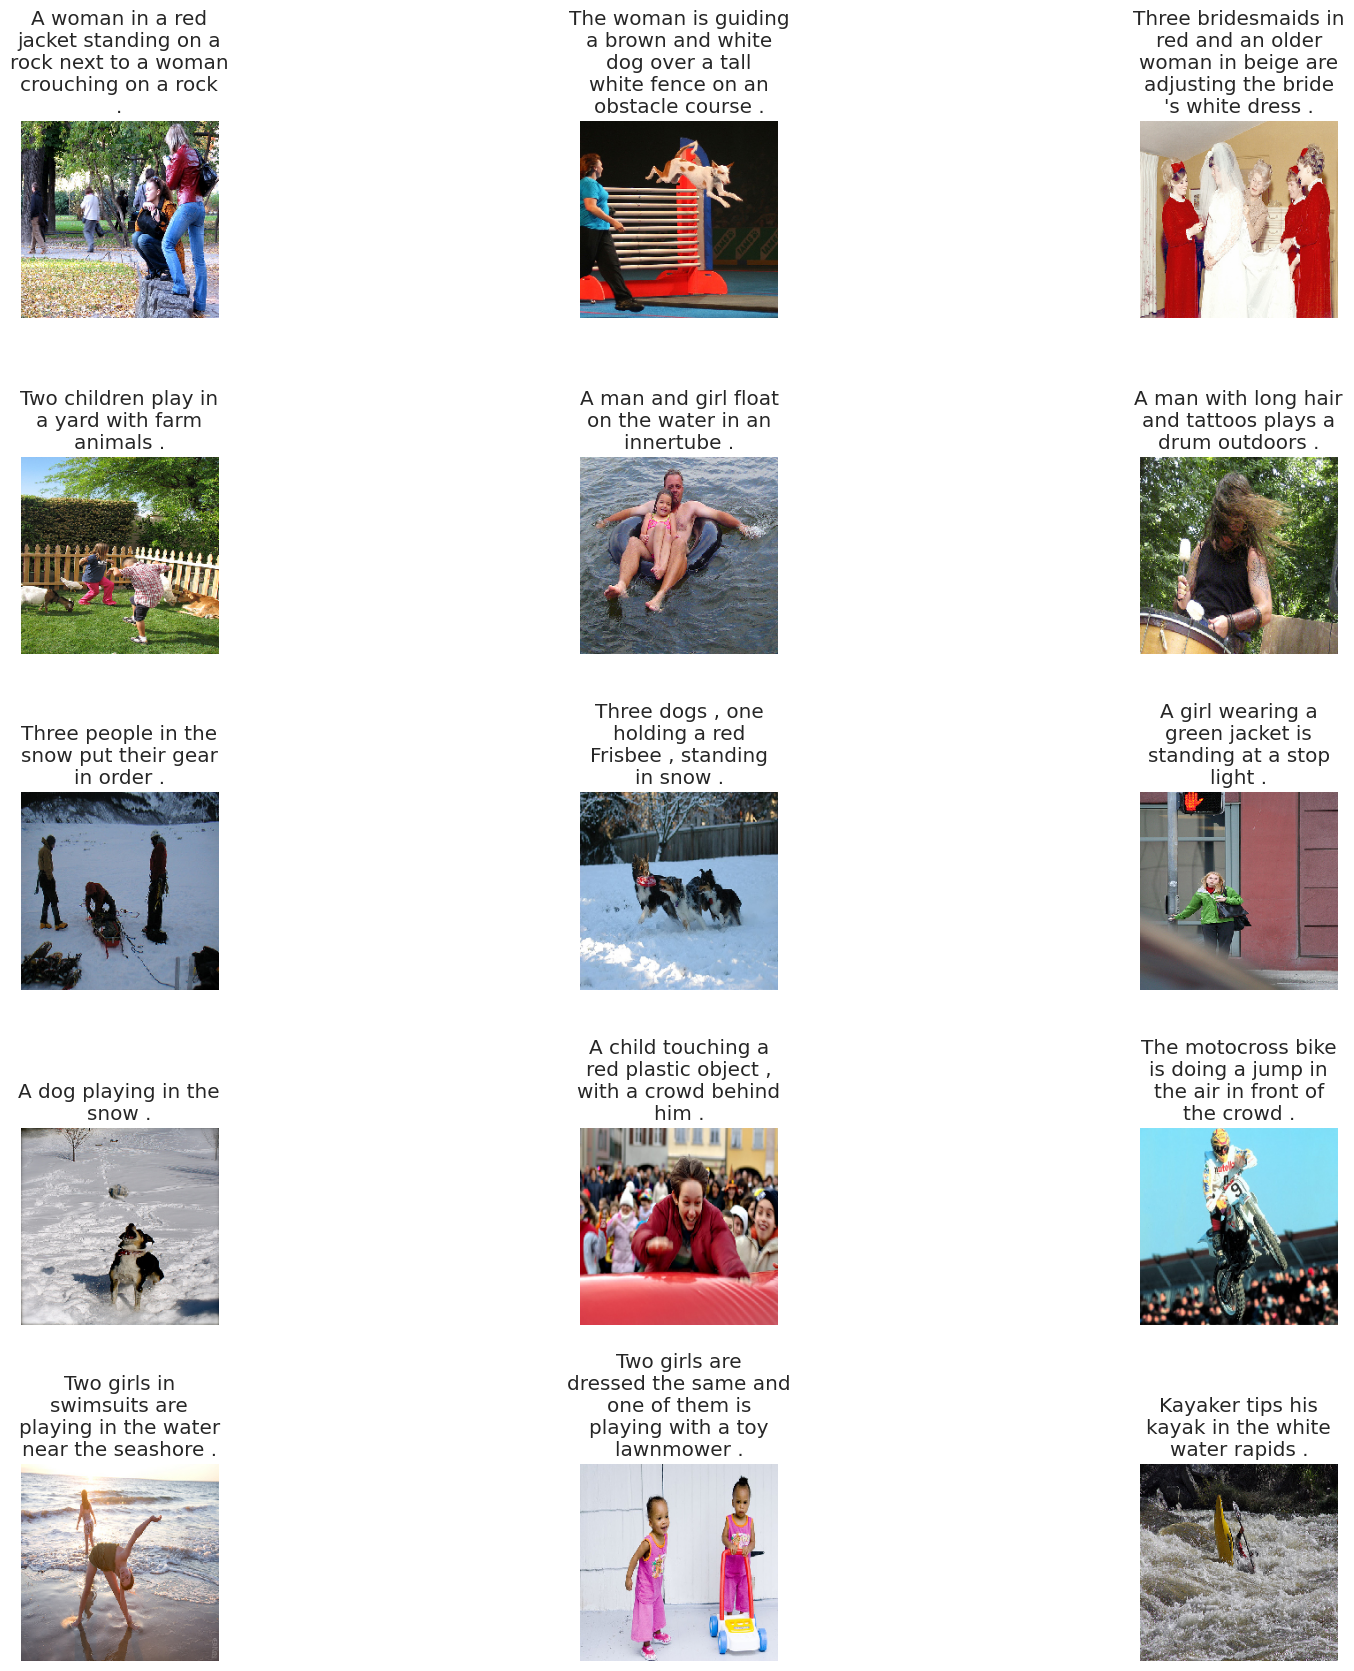

In [6]:
def readImage(path,img_size = 224):
    img = load_img(path,color_mode = 'rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255
    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop = True)
    plt.figure(figsize = (20,20))
    n = len(temp_df)
    k = 0
    for i in range(n):
        k+=1
        plt.subplot(5,3,k)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i],20))) ## About the 20 in wrap()
# The 20 in wrap(temp_df.caption[i], 20) sets the maximum character width per line for the image title. It breaks long captions into multiple lines of 20 characters each, making them more readable in the subplot titles.
        plt.axis("off")
display_images(data.sample(15))

### Caption Text Preprocessing Steps
* Convert sentences into lowercase
* Remove special characters and numbers present in the text
* Remove extra spaces
* Remove single characters
* Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [7]:
## Remove all the special characters
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].apply(lambda x:re.sub(r'[^a-z A-Z 0-9-]+',' ', x))
    data['caption'] = data['caption'].apply(lambda x: " ".join([y for y in x.split() if y not in stopwords.words('english')]))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s"," "))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data
data = text_preprocessing(data)

In [9]:
# ## Lemmatizing:
# # just for show, as a next step but not implementing since RNN can handle huge datasets without lemmatizing
# from nltk.stem import WordNetLemmatizer
# lemmatizer = WordNetLemmatizer()
# def lemmatize_text(text):
#     return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
# data['caption'] = data['caption'].apply(lambda x: lemmatize_text(x))

In [10]:
captions = data['caption'].tolist()

captions[:10]

['startseq child pink dress climbing set stairs entry way endseq',
 'startseq girl going wooden building endseq',
 'startseq little girl climbing wooden playhouse endseq',
 'startseq little girl climbing stairs playhouse endseq',
 'startseq little girl pink dress going wooden cabin endseq',
 'startseq black dog spotted dog fighting endseq',
 'startseq black dog tri-colored dog playing road endseq',
 'startseq black dog white dog brown spots staring street endseq',
 'startseq two dogs different breeds looking road endseq',
 'startseq two dogs pavement moving toward endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
tokenizer.word_index

{'startseq': 1,
 'endseq': 2,
 'dog': 3,
 'man': 4,
 'two': 5,
 'white': 6,
 'black': 7,
 'boy': 8,
 'woman': 9,
 'girl': 10,
 'wearing': 11,
 'people': 12,
 'water': 13,
 'red': 14,
 'young': 15,
 'brown': 16,
 'blue': 17,
 'dogs': 18,
 'running': 19,
 'playing': 20,
 'shirt': 21,
 'standing': 22,
 'ball': 23,
 'little': 24,
 'grass': 25,
 'snow': 26,
 'child': 27,
 'person': 28,
 'jumping': 29,
 'three': 30,
 'front': 31,
 'sitting': 32,
 'holding': 33,
 'field': 34,
 'small': 35,
 'large': 36,
 'green': 37,
 'one': 38,
 'group': 39,
 'yellow': 40,
 'walking': 41,
 'children': 42,
 'men': 43,
 'air': 44,
 'beach': 45,
 'near': 46,
 'mouth': 47,
 'jumps': 48,
 'another': 49,
 'street': 50,
 'runs': 51,
 'riding': 52,
 'stands': 53,
 'bike': 54,
 'girls': 55,
 'outside': 56,
 'rock': 57,
 'next': 58,
 'play': 59,
 'orange': 60,
 'looking': 61,
 'pink': 62,
 'player': 63,
 'camera': 64,
 'pool': 65,
 'hat': 66,
 'jacket': 67,
 'boys': 68,
 'women': 69,
 'around': 70,
 'behind': 71,
 'ba

In [12]:
## padding
# so word encoding is done by tokenizer and caption is a list of sentences
vocab_size = len(tokenizer.word_index) +1
max_len = max(len(caption.split()) for caption in captions)
print(max_len)
# input_sequences = np.array(pad_sequences(captions,maxlen=max_len,padding='pre')) # it should be numeric document

captions_try = tokenizer.texts_to_sequences(captions) # converting the word tokened into texts into sequence of tokens to form sentences
captions_try[:4]

23


[[1, 27, 62, 135, 88, 339, 340, 5060, 607, 2],
 [1, 10, 266, 157, 86, 2],
 [1, 24, 10, 88, 157, 2356, 2],
 [1, 24, 10, 88, 340, 2356, 2]]

In [13]:
captions_try = np.array(pad_sequences(captions_try,maxlen=max_len,padding='pre'))

In [14]:
tokenizer.texts_to_sequences(captions[1])
# The issue occurs because texts_to_sequences() is treating each character in your caption as a separate text input, rather than treating the entire caption as one sentence.

# The Root Cause
# From your output pattern with many single-element lists [[7217], , ...] and empty lists [], it appears that captions is being processed character by character instead of word by word.

# This happens when:

# You pass a string directly to texts_to_sequences() instead of a list containing the string

# The tokenizer wasn't fitted properly on sentence-level data

[[7217],
 [245],
 [2800],
 [8219],
 [245],
 [7217],
 [],
 [],
 [],
 [],
 [5075],
 [8219],
 [],
 [],
 [],
 [2329],
 [5075],
 [2190],
 [],
 [],
 [],
 [2329],
 [2329],
 [],
 [],
 [2190],
 [],
 [5575],
 [3060],
 [5075],
 [],
 [],
 [5075],
 [2190],
 [],
 [],
 [],
 [2190],
 [],
 [7217],
 [],
 []]

In [15]:
captions[:4]

['startseq child pink dress climbing set stairs entry way endseq',
 'startseq girl going wooden building endseq',
 'startseq little girl climbing wooden playhouse endseq',
 'startseq little girl climbing stairs playhouse endseq']

In [16]:
captions_try[:4]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,   27,   62,  135,   88,  339,  340, 5060,  607,
           2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   10,  266,  157,   86,
           2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   24,   10,   88,  157, 2356,
           2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   24,   10,   88,  340, 2356,
           2]], dtype=int32)

In [17]:
## Processing images
images = data['image'].unique().tolist()
nimages  = len(images)

# Train test split for images
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace = True,drop = True)
# Yes, you can use train_test_split, but you need to be careful about the splitting strategy for image captioning datasets.

# The Key Challenge
# In image captioning datasets like Flickr8k, you typically have multiple captions per image (usually 5 captions per image). 
# If you split randomly on the DataFrame rows, you risk having the same image in both train and test sets with different captions, 
# which causes data leakage.

In [18]:
# The key difference between train_images and train is the data structure and content type:

# train_images
# Type: List or array of image filenames/identifiers

# Content: Just the image names (strings)

# Purpose: Contains only the subset of image names for training

# python
# # Example of train_images
# train_images = ['img1.jpg', 'img2.jpg', 'img3.jpg', ...]
# train
# Type: DataFrame with multiple columns

# Content: Complete dataset rows (image-caption pairs and other metadata)

# Purpose: Contains all training data including captions, descriptions, etc.

# python
# # Example of train DataFrame
# train = 
#     image       caption                    other_cols
# 0   img1.jpg    "a dog running in park"   ...
# 1   img1.jpg    "brown dog plays outside" ...  
# 2   img2.jpg    "cat sitting on chair"    ...
# 3   img3.jpg    "red car on street"       ...


# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [19]:
## CNN Model -> will help in extracting features from images
model = DenseNet201()

model = DenseNet201(weights='imagenet')
#fe -> feature extractor
fe = Model(inputs = model.input , outputs = model.layers[-2].output) # we are taking the 2nd last layer from the neural network

img_size = 224
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size = (img_size,img_size))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0) # sometimes dimentions size are small so to expand it in rows
    feature = fe.predict(img, verbose=0) # if we don't want to see progress bar, verbose =0
    features[image] = feature

I0000 00:00:1756705502.973365      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1756705524.809005     106 service.cc:148] XLA service 0x7ad268003830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756705524.810291     106 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756705526.986181     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756705540.259012     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [15:55<00:00,  8.46it/s]


In [20]:
# # Use a simpler model that's more likely to be cached
# from tensorflow.keras.applications import VGG16

# def extract_features():
#     model = VGG16(weights='imagenet')
#     fe = Model(inputs=model.input, outputs=model.layers[-2].output)
    
#     features = {}
#     for image in tqdm(data['image'].unique().tolist()):
#         img = load_img(os.path.join(image_path, image), target_size=(224, 224))
#         img = img_to_array(img)
#         img = img/255
#         img = np.expand_dims(img, axis=0)
        
#         feature = fe.predict(img, verbose=0)
#         features[image] = feature
    
#     return features

# features = extract_features()


In [21]:
# Yes, exactly! The "it/s" metric is specifically from tqdm.

# How tqdm Creates it/s
# When you use:

# python
# for image in tqdm(data['image'].unique().tolist()):
# tqdm automatically:

# ✅ Tracks how many iterations have completed

# ✅ Measures elapsed time

# ✅ Calculates speed as iterations per second (it/s)

# ✅ Displays the progress bar with all metrics

# Without tqdm vs. With tqdm
# Without tqdm:

# python
# for image in data['image'].unique().tolist():
#     # Your code runs silently with no progress info
# With tqdm:

# python
# for image in tqdm(data['image'].unique().tolist()):
#     # Shows: 45%|████▌     | 3645/8091 [07:24<08:59, 8.21it/s]
# What tqdm Displays
# The complete tqdm output shows:

# 45%: Completion percentage

# ████▌: Visual progress bar

# 3645/8091: Current/Total items processed

# [07:24<08:59]: Time elapsed < Estimated time remaining

# 8.21it/s: Speed metric (iterations per second)



# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [22]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_len,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_len,features=features)

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, Dense, Input, concatenate

input1 = Input(shape=(1920,)) # this is for extracting image features
input2 = Input(shape=(max_len,)) # this is for text

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features) # to avoid overfitting we use dropout
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.9700
Epoch 1: val_loss improved from inf to 4.82818, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - loss: 5.9691 - val_loss: 4.8282 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.8351
Epoch 2: val_loss improved from 4.82818 to 4.56775, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 4.8350 - val_loss: 4.5678 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4.5268
Epoch 3: val_loss improved from 4.56775 to 4.46204, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - loss: 4.5268 - val_loss: 4.4620 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 4.3347
Epoch 4: val_loss improved from 4.46204 to 4.39078, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 4.3347 - val_loss: 4.3908 - learning_rate: 0.0010
Epoch 5/

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

In [24]:
history.history

{'loss': [5.468939304351807,
  4.771205425262451,
  4.501848220825195,
  4.3226094245910645,
  4.184426307678223,
  4.07327938079834,
  3.9747121334075928,
  3.888206720352173,
  3.8163135051727295,
  3.6693103313446045,
  3.634005069732666],
 'val_loss': [4.828178882598877,
  4.56775426864624,
  4.462042331695557,
  4.390779495239258,
  4.365289211273193,
  4.361276626586914,
  4.365408420562744,
  4.379804611206055,
  4.394413948059082,
  4.420684337615967,
  4.4336137771606445],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00020000000949949026,
  0.00020000000949949026]}

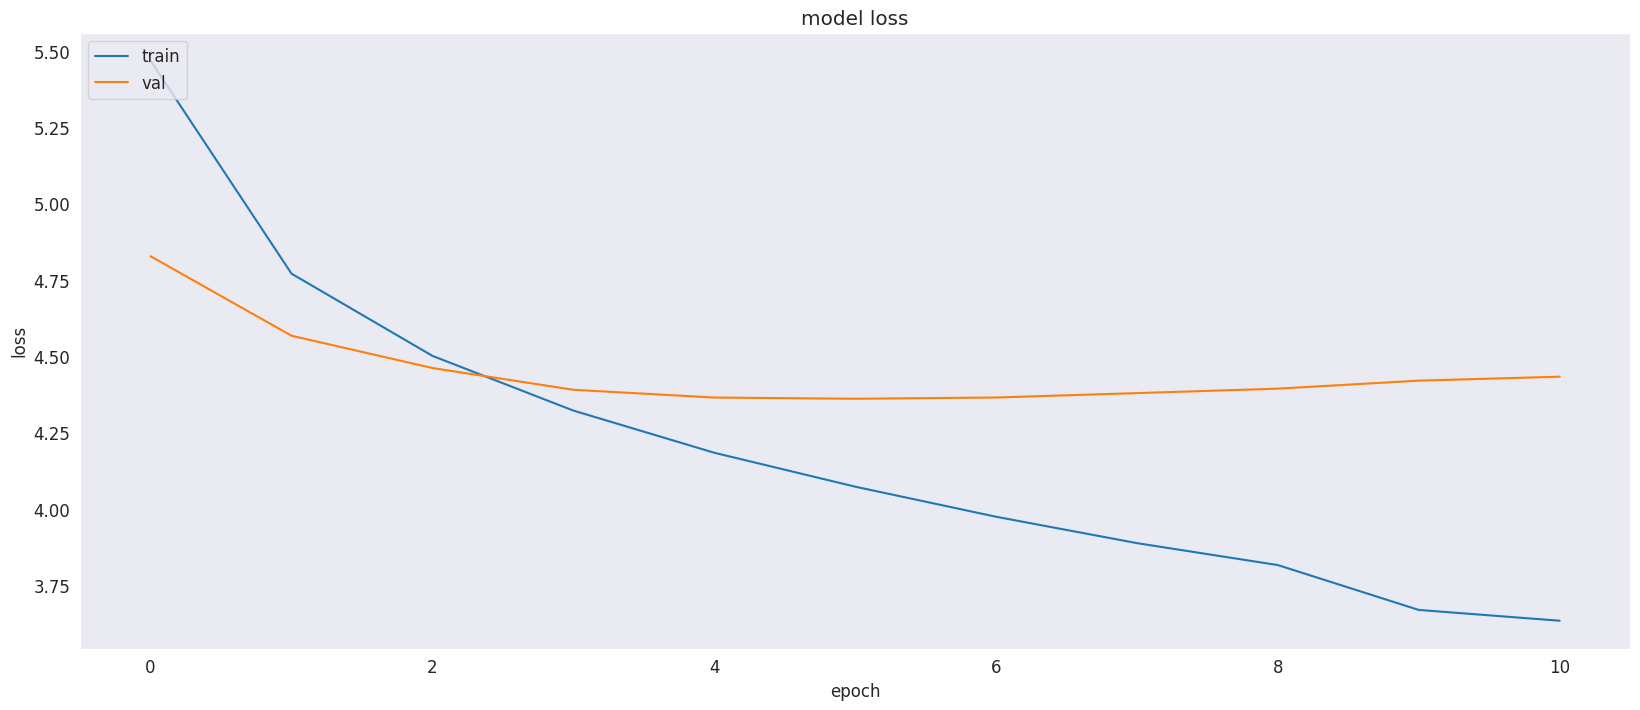

In [25]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [26]:
import pickle
pickle.dump(tokenizer, open("tokenizer.pkl","wb"))

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [35]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=23, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

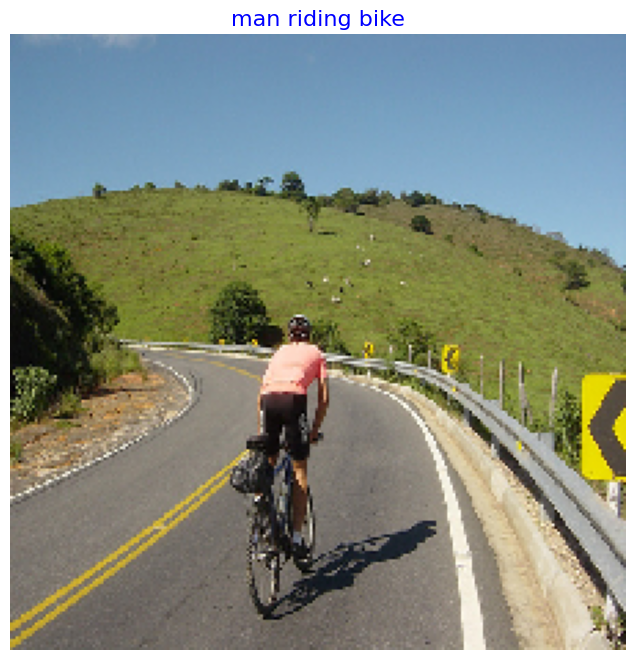

In [36]:
# Example usage
image_path = "/kaggle/input/flickr8k/Images/110595925_f3395c8bd6.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

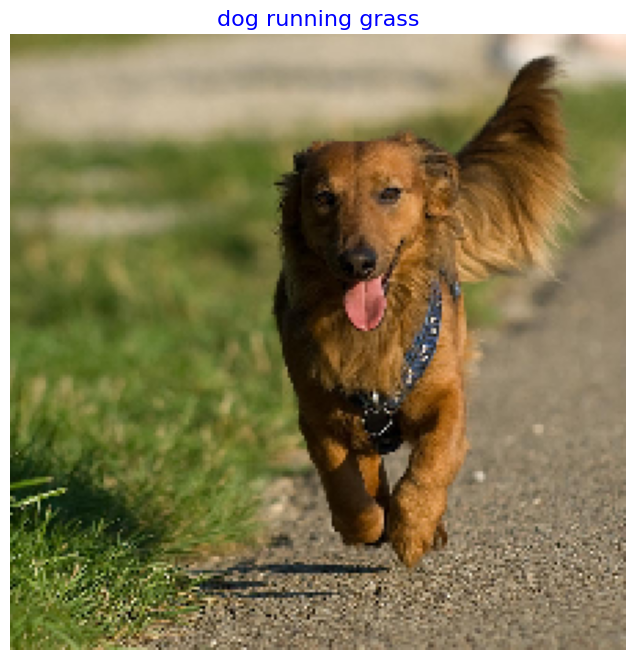

In [37]:
image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

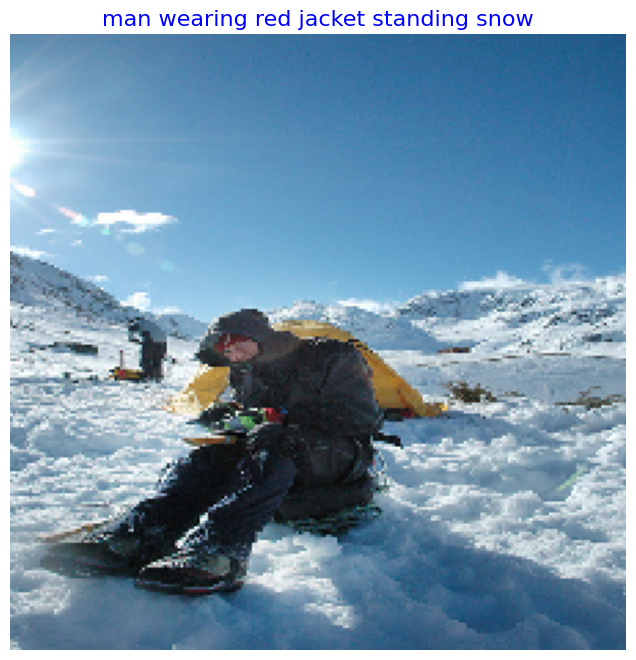

In [38]:
image_path = "/kaggle/input/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)